In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import scipy as scp
import datetime

from sklearn.preprocessing import StandardScaler

import torch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary

import tqdm

import matplotlib.pyplot as plt

from IPython.display import clear_output

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
def select_specific_data(data, datetime_begin, datetime_end):
    """Returns the pd.Dataframe slice for a given time range"""
    
    mask = ((data.loc[:, "time"] >= datetime_begin) & (data.loc[:, "time"] <= datetime_end)).values  
    output = data.iloc[mask, :]
    
    return output


def load_data(filepath):
    
    data = pd.read_csv(filepath,
                   sep=';',
                   names=["time", "price", "2", "3", "4", "5", "6", "7", "8", "9", "delta_price_minute_lag"],)
    
    data.loc[:, "time"] = pd.to_datetime(data.loc[:, "time"],
                                     yearfirst=True,
                                     infer_datetime_format=True)
    return data
    

class StockQuoteDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_frame: pd.Dataframe,
                 time_memory=None, transform=None, predict_horizon=None,
                 verbose=True, fc_ravel=True, daytime_range=None, y_scaling=None) -> StockQuoteDataset:
        """Creates pytorch compatible dataset for stock quotes.
        data_frame (pandas.DataFrame): - time, price, 8 features, target (in predict_horizon is None)
        time_memory (int) default=None:  Number of preceeding steps in seconds (int) to include to the datapoint. 
        transform (int) default=None:  fitted StandardScaler class object do transformations of dataset 
        predict_horizon (int) default=None: time lag to predict the stock pch.
            The target is then provided by the data supplier if None.
        verbose (bool) default=True. Shows the info for uploaded dataset
        fc_ravel (bool) default=True. If True, the x_data is reshaped to the torch.tensor with the shape 
            [StockQuoteDataset.size, time_memory * data_frame.shape[1]]
        daytime_range (datetime, datetime) default=None: - daytime range to filter the data,
        y_scaling (int) default=None: Multiply the target (pct_ch) by a provided factor if specified"""
        
        data_frame = data_frame.copy().dropna()
        self.time_data = data_frame.iloc[:, 0]
        self.data_order = np.arange(0, len(self.time_data))
        self.time_memory = time_memory
        self.transform = transform
        self.x_data = data_frame.iloc[:, 1:-1].values

        if verbose:
            print(data_frame.info())
        
        # Creating/reading the target (pct_ch)
        if predict_horizon is None:
            self.y_data = data_frame.iloc[:, -1].values
        else:
            #time_in_seconds = (data_frame.iloc[:,0] - data_frame.iloc[:,0].min()).dt.total_seconds()
            #pred_price = np.interp(time_in_seconds + predict_horizon,
            #                       time_in_seconds, data_frame.iloc[:,1].values,
            #                       left = np.nan,
            #                       right = np.nan)
            pred_price = data_frame.iloc[:, 1].shift(periods=-predict_horizon)
            pct_ch = (pred_price - data_frame.iloc[:, 1]) / data_frame.iloc[:, 1]
            self.y_data = pct_ch.values

        #Rescaling
        if self.transform is not None:
            self.x_data = self.transform.transform(self.x_data)
        if y_scaling is not None:
            self.y_data = self.y_data * y_scaling
            
        # Converting the data to torch.tensor
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32).reshape((-1, 1))
        
        # Adding the time lag features to the datapoints
        if self.time_memory is None:
            pass
        else:
            x_data_initial = torch.clone(self.x_data)
            if fc_ravel:
                self.x_data = torch.empty((x_data_initial.shape[0], x_data_initial.shape[1] * (time_memory + 1)),
                                           dtype=torch.float32)
            else:
                self.x_data = torch.empty((x_data_initial.shape[0], (time_memory + 1), x_data_initial.shape[1]),
                                           dtype=torch.float32)
            for ii in range(x_data_initial.shape[0]):
                if ii - self.time_memory >= 0:
                    if fc_ravel:
                        self.x_data[ii, :] = x_data_initial[ii - self.time_memory:ii + 1, :].ravel()
                    else:
                        self.x_data[ii, :] = x_data_initial[ii - self.time_memory:ii + 1, :]
                else:
                    padding = x_data_initial[0, :].repeat(self.time_memory - ii, 1)
                    remaining_x = x_data_initial[0:ii + 1, :]
                    if fc_ravel:
                        self.x_data[ii, :] = torch.cat((padding, remaining_x), 0).ravel()
                    else:
                        self.x_data[ii, :] = torch.cat((padding, remaining_x), 0)
            
            if not fc_ravel:
                self.x_data = torch.permute(self.x_data, (0,2,1))
        
        # Filtering the nan values
        mask = np.isfinite(self.y_data.numpy().ravel()) 
        # Filtering by daytime_range
        if daytime_range is not None:
            mask = (mask 
                    & (self.time_data.dt.time >= daytime_range[0]).values 
                    & (self.time_data.dt.time <= daytime_range[1]).values)
        
        # Filtering the daytime range
        self.x_data = self.x_data[mask,:]
        self.y_data = self.y_data[mask]
        self.time_data = self.time_data[mask]
    
    def __len__(self):
        return self.x_data.shape[0]
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return (self.x_data[idx, :],
                self.y_data[idx, :],
                self.data_order[idx])
    

def calculate_model_prediction(model, dataloader):
    
    output = []
    idxs = []
    model.eval()
    with torch.no_grad():

        for batch, (X, y, idx) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            output.append(model(X).cpu().numpy().ravel())
            idxs.append(idx.numpy())
            
        idxs = np.hstack(idxs)
        output = np.hstack(output)
        output = output[np.argsort(idxs)]
        
        return output
    

def train(dataloader, model, loss_func, optimizer, scheduler):
    
    size = len(dataloader.dataset)
    
    model.train()
    
    print(f"Optimization stage: {len(dataloader)} batches")
    for batch, (X, y, _) in tqdm.notebook.tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        X, y = X.cpu(), y.cpu()
    scheduler.step()


    train_loss = 0.0
    model.eval()
    print(f"Loss computation stage: {len(dataloader)} batches")
    with torch.no_grad():
        for batch, (X, y, _) in tqdm.notebook.tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            train_loss += loss_func(pred, y).item() * len(y)

    train_loss /= size

    return train_loss


def validation(dataloader, model, loss_func):
    
    size = len(dataloader.dataset)
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        print(f"Validation Loss computation stage: {len(dataloader)} batches")
        for batch, (X, y, _) in tqdm.notebook.tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            validation_loss += loss_func(pred, y).item() * len(y)

    validation_loss /= size
    
    return validation_loss


def plot_config(num_epochs):
    
    plt.xscale("linear")
    plt.yscale("log")
    plt.grid(True)
    plt.xlabel("epochs")
    plt.xlim([0, num_epochs + 1])
    plt.ylabel("MSEloss")
    plt.legend()
    plt.show() 

## 1 Data Processing

### 1.1 Выбор данных для теста, обучения и валидации

In [ ]:
DATAPATH = "data//gen-SBER.csv"

data = pd.read_csv(DATAPATH,
                   sep=';',
                   names=["time", "price", "2", "3", "4", "5", "6", "7", "8", "9", "10", "delta_price_minute_lag"],)
data = data.drop(columns="10")
data.loc[:, "time"] = pd.to_datetime(data.loc[:, "time"],
                                     yearfirst=True,
                                     infer_datetime_format=True)

plt.figure(figsize=(16,9))
plt.plot(data.iloc[:,0], data.iloc[:,1])

data.info()

In [ ]:
DATETIMES_TRAIN = (datetime.datetime.fromisoformat('2021-09-01 00:00:00.000'),
                   datetime.datetime.fromisoformat('2021-11-01 00:00:00.000'))

DATETIMES_VALIDATION = (datetime.datetime.fromisoformat('2021-11-01 00:01:00.000'),
                        datetime.datetime.fromisoformat('2021-11-14 00:00:00.000'))

DATETIMES_TEST = (datetime.datetime.fromisoformat('2021-11-14 00:01:00.000'),
                  datetime.datetime.fromisoformat('2021-11-28 00:00:00.000'))

In [ ]:
train_data = select_specific_data(data, DATETIMES_TRAIN[0], DATETIMES_TRAIN[1])
validation_data = select_specific_data(data, DATETIMES_VALIDATION[0], DATETIMES_VALIDATION[1])
test_data =  select_specific_data(data, DATETIMES_TEST[0], DATETIMES_TEST[1])

train_data.to_csv("data//gen-SBER_train.csv", sep=";", header=None, index=False)
validation_data.to_csv("data//gen-SBER_validation.csv", sep=";", header=None, index=False)
test_data.to_csv("data//gen-SBER_test.csv", sep=";", header=None, index=False)

### 1.2 Выгрузка данных для обучения и валидации

In [ ]:
TRAIN_DATAPATH = "data//gen-Sber_train.csv"
VALIDATION_DATAPATH = "data//gen-Sber_validation.csv"
TEST_DATAPATH = "data//gen-Sber_test.csv"

DAYTIME_RANGE = (datetime.time.fromisoformat("10:05:00"), 
                 datetime.time.fromisoformat("18:35:59"))

TIME_MEMORY = 240
MODEL_SAVEPATH = "cnn_model_state_dict_scaled_lstm.pt"
DATA_OUT_SAVEPATH = "data_out_scaled_cnn_model_lstm.csv"
DO_SCALING = True
FC_RAVEL = False
PREDICT_HORIZON = 60
Y_SCALING = 1000


train_data = load_data(TRAIN_DATAPATH)
validation_data = load_data(VALIDATION_DATAPATH)
test_data = load_data(TEST_DATAPATH)

#Scaling
if DO_SCALING:
    transform = StandardScaler()
    transform.fit(train_data.iloc[:, 1:-1].values)
else:
    transform = None

train_dataset = StockQuoteDataset(train_data,
                                  time_memory=TIME_MEMORY,
                                  transform = transform,
                                  verbose=False,
                                  fc_ravel=FC_RAVEL,
                                  predict_horizon=PREDICT_HORIZON,
                                  y_scaling=Y_SCALING,
                                  daytime_range=DAYTIME_RANGE)
validation_dataset = StockQuoteDataset(validation_data,
                                       time_memory=TIME_MEMORY,
                                       transform = transform,
                                       verbose=False,
                                       fc_ravel=FC_RAVEL,
                                       predict_horizon=PREDICT_HORIZON,
                                       y_scaling=Y_SCALING,
                                       daytime_range=DAYTIME_RANGE)
test_dataset = StockQuoteDataset(test_data,
                                 time_memory=TIME_MEMORY,
                                 transform = transform,
                                 verbose=False,
                                 fc_ravel=FC_RAVEL,
                                 predict_horizon=PREDICT_HORIZON,
                                 y_scaling=Y_SCALING,
                                 daytime_range=DAYTIME_RANGE)

In [5]:
train_dataset[1:5][0].shape

torch.Size([4, 9, 241])

In [6]:
TRAIN_BATCH_SIZE = 1024
VALIDATION_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=0,
                                           pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=VALIDATION_BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=TEST_BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)

### 2.1 Пробная FC модель

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=9, num_classes=1, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 100),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(10, num_classes),

        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
model = TinyNeuralNetwork(9 * (TIME_MEMORY + 1)).to(device)
loss_func = nn.MSELoss()

torchsummary.summary(model.to(device), (9 * (TIME_MEMORY + 1),))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 2169]           4,338
            Linear-2                  [-1, 100]         217,000
              ReLU-3                  [-1, 100]               0
           Dropout-4                  [-1, 100]               0
       BatchNorm1d-5                  [-1, 100]             200
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
           Dropout-8                  [-1, 100]               0
       BatchNorm1d-9                  [-1, 100]             200
           Linear-10                  [-1, 100]          10,100
             ReLU-11                  [-1, 100]               0
          Dropout-12                  [-1, 100]               0
      BatchNorm1d-13                  [-1, 100]             200
           Linear-14                  [

### 2.2 CNN модель

In [22]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
        self.model = nn.Sequential(
           nn.Conv1d(in_channels=9, out_channels=32, kernel_size=3, stride=1, padding=0),
           nn.ReLU(),
           nn.BatchNorm1d(32),
           
           nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
           nn.BatchNorm1d(64),
           nn.ReLU(),


           nn.MaxPool1d(kernel_size=7),
            
           nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding=0),
           nn.BatchNorm1d(128),
           nn.ReLU(),

      
           nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
           nn.BatchNorm1d(128),
           nn.ReLU(),

            
           nn.MaxPool1d(kernel_size=5),

           nn.Flatten(), 
           nn.Dropout(0.3),
            
           nn.BatchNorm1d(num_features=512),
           nn.Linear(in_features=512, out_features=256),
           nn.ReLU(),
           
           nn.Linear(in_features=256, out_features=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
model = CNNNetwork().to(device)
loss_func = nn.MSELoss()

torchsummary.summary(model.to(device), (9, TIME_MEMORY + 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 239]             896
              ReLU-2              [-1, 32, 239]               0
       BatchNorm1d-3              [-1, 32, 239]              64
            Conv1d-4              [-1, 64, 233]          14,400
       BatchNorm1d-5              [-1, 64, 233]             128
              ReLU-6              [-1, 64, 233]               0
         MaxPool1d-7               [-1, 64, 33]               0
            Conv1d-8              [-1, 128, 23]          90,240
       BatchNorm1d-9              [-1, 128, 23]             256
             ReLU-10              [-1, 128, 23]               0
           Conv1d-11              [-1, 128, 21]          49,280
      BatchNorm1d-12              [-1, 128, 21]             256
             ReLU-13              [-1, 128, 21]               0
        MaxPool1d-14               [-1,

## 2.3 CNN-LSTM модель

In [85]:
class CNNLSTMNetwork(nn.Module):
    def __init__(self, predict_horizon=60):
        super(self.__class__, self).__init__()
        
        self.predict_horizon = predict_horizon
        
        self.encoder = nn.Sequential(
           nn.Conv1d(in_channels=9, out_channels=32, kernel_size=3, stride=1, padding=0),
           nn.ReLU(),
           nn.BatchNorm1d(32),
           
           nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
           nn.BatchNorm1d(64),
           nn.ReLU(),

           nn.MaxPool1d(kernel_size=7),
            
           nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding=0),
           nn.BatchNorm1d(128),
           nn.ReLU(),
      
           nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
           nn.BatchNorm1d(128),
           nn.ReLU(),

           nn.MaxPool1d(kernel_size=5),
            

           nn.Flatten(), 
           
           nn.Dropout(0.3),
            
           nn.BatchNorm1d(num_features=512),
           nn.Linear(in_features=512, out_features=256),
           nn.ReLU(),
        )
        
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            num_layers=2, dropout=0.2,
                            batch_first=True)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(in_features=128, out_features=1),
        )
        

    def forward(self, inp):   
        repeated_encoded_vector = self.encoder(inp)
        
        repeated_encoded_vector = repeated_encoded_vector.expand(self.predict_horizon, -1, -1).permute(1,0,2)
        
        lstm_output, (h_t, c_t)= self.lstm(repeated_encoded_vector)
        
        lstm_output = lstm_output[:, -1, :].squeeze()
        
        output = self.decoder(lstm_output)
        
        return output
    
model = CNNLSTMNetwork(predict_horizon=60).to(device)
loss_func = nn.MSELoss()

#torchsummary.summary(model.to(device), (9, TIME_MEMORY + 1), batch_size=1024)

# 3 Optimization

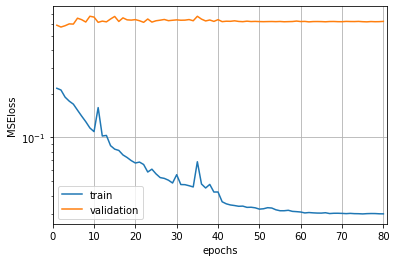

In [87]:
%matplotlib inline

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)

lr_factors = [1.] * 40 + [1e-1] * 20 + [1e-2] * 21

scheduler = torch.optim.lr_scheduler.LambdaLR(opt,
                                              lr_lambda = lambda x: lr_factors[x],
                                              verbose=True)

epoch = len(lr_factors) - 1

num_epoch = []
train_losses = []
validation_losses = []


for t in range(epoch):
    train_loss = train(train_loader, model, loss_func, opt, scheduler)
    validation_loss = validation(validation_loader, model, loss_func)

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)


    num_epoch.append(t + 1)    

    clear_output(wait=True)

    plt.plot(num_epoch, train_losses, label="train")
    plt.plot(num_epoch, validation_losses, label="validation")
    plot_config(epoch)

In [88]:
torch.save(model.state_dict(), MODEL_SAVEPATH)

### Output data generation

In [92]:
model.eval()

y_pred_train = calculate_model_prediction(model, train_loader)
y_pred = calculate_model_prediction(model, validation_loader)
y_pred_test = calculate_model_prediction(model, test_loader)

if DO_SCALING:           
    y_pred_train = y_pred_train / Y_SCALING
    y_pred = y_pred / Y_SCALING
    y_pred_test = y_pred_test / Y_SCALING

In [96]:
train_dataset.x_data.size()

torch.Size([1212787, 9, 241])

In [97]:
def create_output_dataset(dataset, y_pred, transform=None, do_scaling=DO_SCALING, y_scaling=Y_SCALING):
    columns = ["time", "target", "f1", "f2", "f2", "f4", "f5", "f6", "f7", "f8", "pct_ch", "pred", "pred_pct_ch"]
    data_out = pd.DataFrame(columns=columns)
    data_out.pred_pct_ch = y_pred
    data_out.time = dataset.time_data
    data_out.pct_ch = dataset[:][1].numpy().ravel()
    print(dataset.x_data[:,0,-1].shape, dataset.time_data.shape, y_pred.shape)
    
    data_out.target = dataset.x_data[:,0, -1].numpy().ravel()

    if do_scaling:
        data_out.pct_ch = dataset[:][1].numpy().ravel() / y_scaling
        data_out.target = data_out.target * transform.scale_[0] + transform.mean_[0]

    data_out.pred = data_out.target * (1 + data_out.pred_pct_ch)
    #data_out.target = data_out.target * (1 + data_out.pct_ch)
    
    return data_out

In [98]:
data_out_train = create_output_dataset(train_dataset, y_pred_train, transform=transform)
data_out_validation = create_output_dataset(validation_dataset, y_pred, transform=transform)
data_out_test = create_output_dataset(test_dataset, y_pred_test, transform=transform)

torch.Size([1212787]) (1212787,) (1212787,)
torch.Size([254448]) (254448,) (254448,)
torch.Size([270938]) (270938,) (270938,)


In [99]:
LIM_LOWER = 0
LIM_UPPER = 20000 #10_000

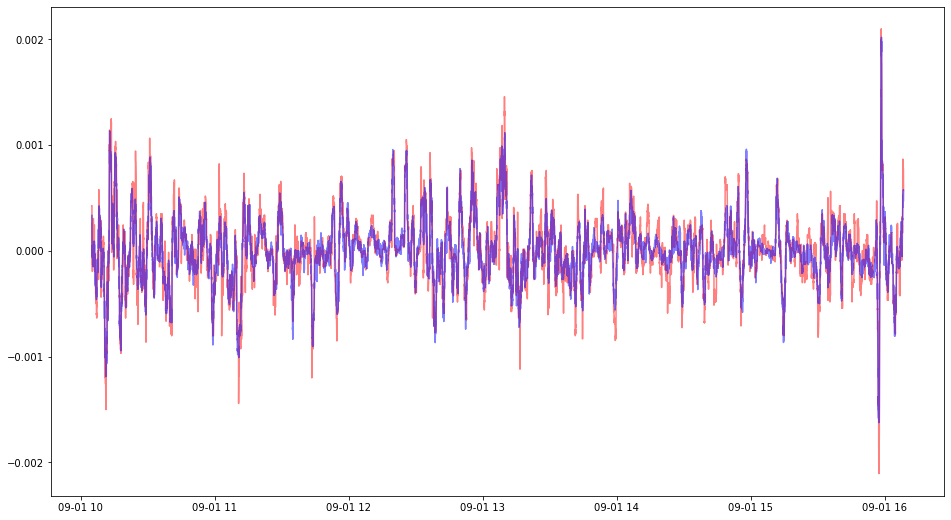

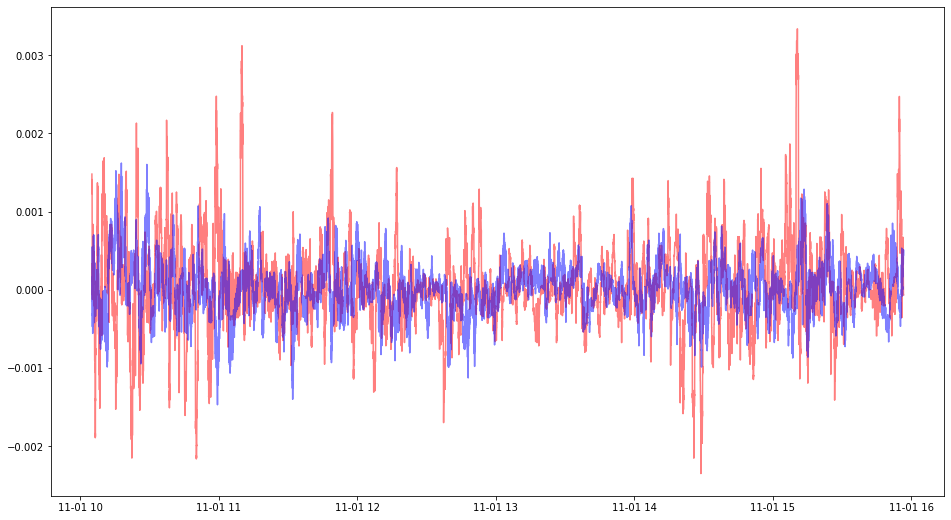

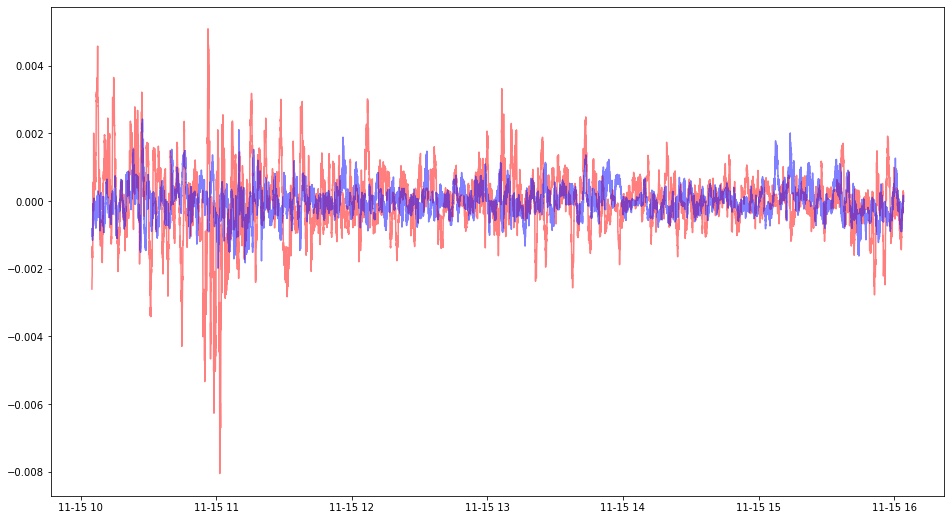

In [100]:
%matplotlib inline 
for data in (data_out_train, data_out_validation, data_out_test):
    plt.figure(figsize=(16,9))
    if DO_SCALING:
        plt.plot(data["time"][LIM_LOWER:LIM_UPPER], data["pct_ch"][LIM_LOWER:LIM_UPPER], "r-", alpha=0.5)
        plt.plot(data["time"][LIM_LOWER:LIM_UPPER], data["pred_pct_ch"][LIM_LOWER:LIM_UPPER], "b-", alpha=0.5)
    else:
        plt.plot(data["time"][LIM_LOWER:LIM_UPPER], data["pct_ch"][LIM_LOWER:LIM_UPPER], "r-", alpha=0.5)
        plt.plot(data["time"][LIM_LOWER:LIM_UPPER], data["pred_pct_ch"][LIM_LOWER:LIM_UPPER], "b-", alpha=0.5)

### Data saving

In [101]:
data_out_validation.to_csv(DATA_OUT_SAVEPATH, index=False, sep=",")
data_out_validation.head()
data_out_test.to_csv(DATA_OUT_SAVEPATH[:-4] + "_test" + ".csv", index=False, sep=",")
data_out_test.head()

,time,target,f1,f2,f2,f4,f5,f6,f7,f8,pct_ch,pred,pred_pct_ch
0,NaT,348.789978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001247,348.820465,0.000087
1,NaT,349.005005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000587,349.077271,0.000207
2,NaT,349.005005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000487,349.149292,0.000413
3,NaT,349.035004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000544,349.177917,0.000410
4,NaT,349.029999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000186,349.177704,0.000423


In [106]:
pd.read_csv(TRAIN_DATAPATH, sep=";").head(n=50)

,2021-09-01 10:00:00.462,328.83,553817.08,476203.76,0.0,0.0.1,32044377.3,2231559.8,822575.0,821600.0,0.000654
0,2021-09-01 10:00:01.464,328.780,1447936.83,350819.09,-0.000151,-0.000152,24601136.2,5631846.0,-6722489.1,-3720894.7,0.000654
1,2021-09-01 10:00:02.467,328.700,2449442.18,323170.52,-0.000390,-0.000395,24499778.0,10015699.7,3521992.7,8632933.6,0.001110
2,2021-09-01 10:00:03.475,328.730,0.00,123657.36,-0.000296,-0.000303,29083406.4,7875132.4,4583628.4,3310694.6,0.001000
3,2021-09-01 10:00:04.496,328.845,32562.09,0.00,0.000053,0.000046,24803537.6,6854323.4,-9901073.7,1941832.4,0.000654
4,2021-09-01 10:00:05.587,328.895,0.00,0.00,0.000203,0.000198,22307052.4,8900178.3,-2499777.1,3238441.1,0.000502
5,2021-09-01 10:00:06.714,328.890,0.00,0.00,0.000186,0.000183,22129518.0,9630697.4,-177534.4,730519.1,0.000547
6,2021-09-01 10:00:07.715,328.890,0.00,0.00,0.000185,0.000183,22096627.0,10051614.6,-32891.0,420917.2,0.000562
7,2021-09-01 10:00:08.758,328.890,0.00,0.00,0.000183,0.000182,22096627.0,14940785.0,0.0,4889170.4,0.000547
8,2021-09-01 10:00:09.816,328.890,0.00,0.00,0.000181,0.000182,25419520.0,14940785.0,3322893.0,0.0,0.000578
9,2021-09-01 10:00:10.820,328.910,169389.85,25980.73,0.000239,0.000243,28211071.4,14004648.9,2189060.5,4133699.0,0.000486


# 